## 什么是DQN

### 强化学习与神经网络

之前我们所谈论到的强化学习方法都是比较传统的方式, 而如今, 随着机器学习在日常生活中的各种应用, 各种机器学习方法也在融汇, 合并, 升级. 而我们今天所要探讨的强化学习则是这么一种融合了神经网络和 Q learning 的方法, 名字叫做 Deep Q Network. 这种新型结构是为什么被提出来呢? 原来, 传统的表格形式的强化学习有这样一个瓶颈.
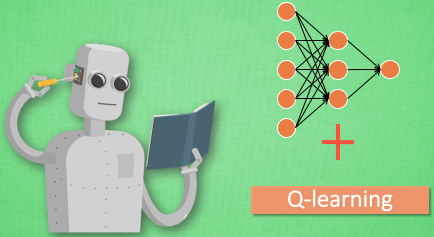

### 神经网络的作用

我们使用表格来存储每一个状态 state, 和在这个 state 每个行为 action 所拥有的 Q 值. 而当今问题是在太复杂, 状态可以多到比天上的星星还多(比如下围棋). 如果全用表格来存储它们, 恐怕我们的计算机有再大的内存都不够, 而且每次在这么大的表格中搜索对应的状态也是一件很耗时的事. 不过, 在机器学习中, 有一种方法对这种事情很在行, 那就是神经网络. 我们可以将状态和动作当成神经网络的输入, 然后经过神经网络分析后得到动作的 Q 值, 这样我们就没必要在表格中记录 Q 值, 而是直接使用神经网络生成 Q 值. 还有一种形式的是这样, 我们也能只输入状态值, 输出所有的动作值, 然后按照 Q learning 的原则, 直接选择拥有最大值的动作当做下一步要做的动作. 我们可以想象, 神经网络接受外部的信息, 相当于眼睛鼻子耳朵收集信息, 然后通过大脑加工输出每种动作的值, 最后通过强化学习的方式选择动作.
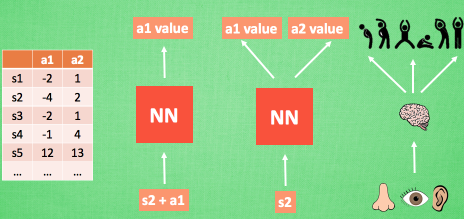

### 更新神经网络

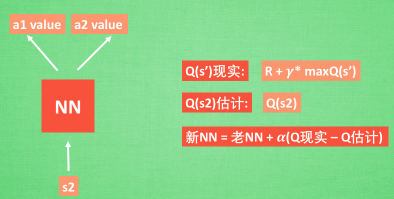
接下来我们基于第二种神经网络来分析, 我们知道, 神经网络是要被训练才能预测出准确的值. 那在强化学习中, 神经网络是如何被训练的呢? 首先, 我们需要 a1, a2 正确的Q值, 这个 Q 值我们就用之前在 Q learning 中的 Q 现实来代替. 同样我们还需要一个 Q 估计 来实现神经网络的更新. 所以神经网络的的参数就是老的 NN 参数 加学习率 alpha 乘以 Q 现实 和 Q 估计 的差距. 我们整理一下.

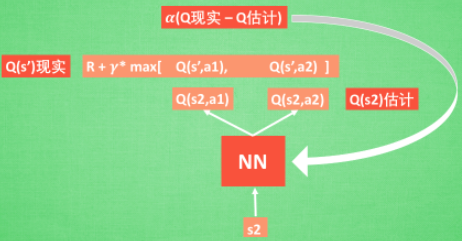
我们通过 NN 预测出Q(s2, a1) 和 Q(s2,a2) 的值, 这就是 Q 估计. 然后我们选取 Q 估计中最大值的动作来换取环境中的奖励 reward. 而 Q 现实中也包含从神经网络分析出来的两个 Q 估计值, 不过这个 Q 估计是针对于下一步在 s' 的估计. 最后再通过刚刚所说的算法更新神经网络中的参数. 但是这并不是 DQN 会玩电动的根本原因. 还有两大因素支撑着 DQN 使得它变得无比强大. 这两大因素就是 Experience replay 和 Fixed Q-targets.


### DQN 两大利器

简单来说, DQN 有一个记忆库用于学习之前的经历. 在之前的简介影片中提到过, Q learning 是一种 off-policy 离线学习法, 它能学习当前经历着的, 也能学习过去经历过的, 甚至是学习别人的经历. 所以每次 DQN 更新的时候, 我们都可以随机抽取一些之前的经历进行学习. 随机抽取这种做法打乱了经历之间的相关性, 也使得神经网络更新更有效率. Fixed Q-targets 也是一种打乱相关性的机理, 如果使用 fixed Q-targets, 我们就会在 DQN 中使用到两个结构相同但参数不同的神经网络, **预测 Q 估计 的神经网络具备最新的参数, 而预测 Q 现实 的神经网络使用的参数则是很久以前的.** 有了这两种提升手段, DQN 才能在一些游戏中超越人类.(fixed q-target：暂时冻结q-target：暂时冻结Q现实对应的神经网络参数，切断相关性）
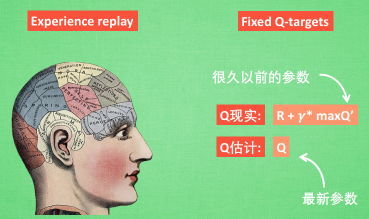

## DQN 算法更新

### 要点

Deep Q Network 的简称叫 DQN, 是将 Q learning 的优势 和 Neural networks 结合了. 如果我们使用 tabular Q learning, 对于每一个 state, action 我们都需要存放在一张 q_table 的表中. 如果像显示生活中, 情况可就比那个迷宫的状况复杂多了, 我们有千千万万个 state, 如果将这千万个 state 的值都放在表中, 受限于我们计算机硬件, 这样从表中获取数据, 更新数据是没有效率的. 这就是 DQN 产生的原因了. 我们可以使用神经网络来 估算 这个 state 的值, 这样就不需要一张表了.

这次的教程我们还是基于熟悉的 迷宫 环境, 重点在实现 DQN 算法, 之后我们再拿着做好的 DQN 算法去跑其他更有意思的环境.

### 算法

下图Φ表示状态
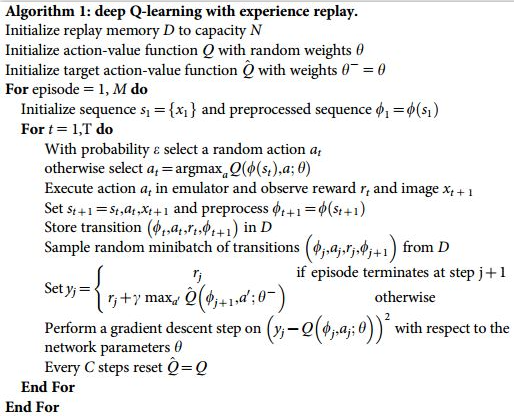

整个算法乍看起来很复杂, 不过我们拆分一下, 就变简单了. 也就是个 Q learning 主框架上加了些装饰.

这些装饰包括:

记忆库 (用于重复学习)

神经网络计算 Q 值

暂时冻结 q_target 参数 (切断相关性)

In [1]:
"""
Reinforcement learning maze example.
Red rectangle:          explorer.
Black rectangles:       hells       [reward = -1].
Yellow bin circle:      paradise    [reward = +1].
All other states:       ground      [reward = 0].
This script is the environment part of this example.
The RL is in RL_brain.py.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
"""
import numpy as np
import time
import sys
if sys.version_info.major == 2:
    import Tkinter as tk
else:
    import tkinter as tk

UNIT = 40   # pixels
MAZE_H = 4  # grid height
MAZE_W = 4  # grid width


class Maze(tk.Tk, object):
    def __init__(self):
        super(Maze, self).__init__()
        self.action_space = ['u', 'd', 'l', 'r']
        self.n_actions = len(self.action_space)
        self.n_features = 2
        self.title('maze')
        self.geometry('{0}x{1}'.format(MAZE_W * UNIT, MAZE_H * UNIT))
        self._build_maze()

    def _build_maze(self):
        self.canvas = tk.Canvas(self, bg='white',
                           height=MAZE_H * UNIT,
                           width=MAZE_W * UNIT)

        # create grids
        for c in range(0, MAZE_W * UNIT, UNIT):
            x0, y0, x1, y1 = c, 0, c, MAZE_H * UNIT
            self.canvas.create_line(x0, y0, x1, y1)
        for r in range(0, MAZE_H * UNIT, UNIT):
            x0, y0, x1, y1 = 0, r, MAZE_W * UNIT, r
            self.canvas.create_line(x0, y0, x1, y1)

        # create origin
        origin = np.array([20, 20])

        # hell
        hell1_center = origin + np.array([UNIT * 2, UNIT])
        self.hell1 = self.canvas.create_rectangle(
            hell1_center[0] - 15, hell1_center[1] - 15,
            hell1_center[0] + 15, hell1_center[1] + 15,
            fill='black')
        # hell
        # hell2_center = origin + np.array([UNIT, UNIT * 2])
        # self.hell2 = self.canvas.create_rectangle(
        #     hell2_center[0] - 15, hell2_center[1] - 15,
        #     hell2_center[0] + 15, hell2_center[1] + 15,
        #     fill='black')

        # create oval
        oval_center = origin + UNIT * 2
        self.oval = self.canvas.create_oval(
            oval_center[0] - 15, oval_center[1] - 15,
            oval_center[0] + 15, oval_center[1] + 15,
            fill='yellow')

        # create red rect
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')

        # pack all
        self.canvas.pack()

    def reset(self):
        self.update()
        time.sleep(0.1)
        self.canvas.delete(self.rect)
        origin = np.array([20, 20])
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')
        # return observation
        return (np.array(self.canvas.coords(self.rect)[:2]) - np.array(self.canvas.coords(self.oval)[:2]))/(MAZE_H*UNIT)

    def step(self, action):
        s = self.canvas.coords(self.rect)
        base_action = np.array([0, 0])
        if action == 0:   # up
            if s[1] > UNIT:
                base_action[1] -= UNIT
        elif action == 1:   # down
            if s[1] < (MAZE_H - 1) * UNIT:
                base_action[1] += UNIT
        elif action == 2:   # right
            if s[0] < (MAZE_W - 1) * UNIT:
                base_action[0] += UNIT
        elif action == 3:   # left
            if s[0] > UNIT:
                base_action[0] -= UNIT

        self.canvas.move(self.rect, base_action[0], base_action[1])  # move agent

        next_coords = self.canvas.coords(self.rect)  # next state

        # reward function
        if next_coords == self.canvas.coords(self.oval):
            reward = 1
            done = True
        elif next_coords in [self.canvas.coords(self.hell1)]:
            reward = -1
            done = True
        else:
            reward = 0
            done = False
        s_ = (np.array(next_coords[:2]) - np.array(self.canvas.coords(self.oval)[:2]))/(MAZE_H*UNIT)
        return s_, reward, done

    def render(self):
        # time.sleep(0.01)
        self.update()

## DQN 神经网络

### 两个神经网络

为了使用 Tensorflow 来实现 DQN, 比较推荐的方式是搭建两个神经网络, target_net 用于预测 q_target 值, 他不会及时更新参数。eval_net 用于预测 q_eval, 这个神经网络拥有最新的神经网络参数。不过这两个神经网络结构是完全一样的, 只是里面的参数不一样. 在这个短视频里, 能找到我们为什么要建立两个不同参数的神经网络.
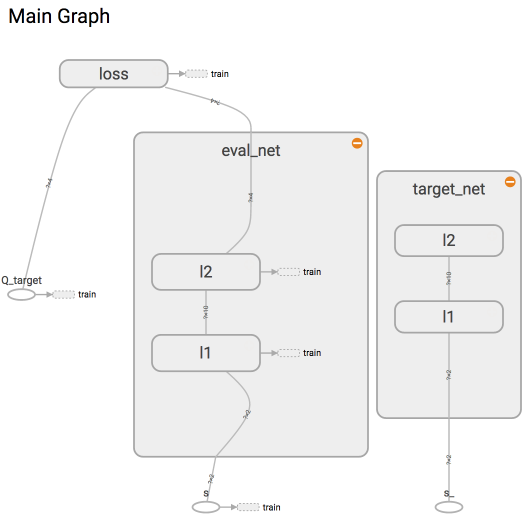

### 神经网络结构

因为 DQN 的结构相比之前所讲的内容都不一样, 所以我们不使用继承来实现这次的功能. 这次我们创建一个 DeepQNetwork 的 class, 以及他神经网络部分的功能. 下次再说强化学习的更新部分.

class DeepQNetwork:
    # 建立神经网络
    def _build_net(self):

### 创建两个网络

两个神经网络是为了固定住一个神经网络 (target_net) 的参数, target_net 是 eval_net 的一个历史版本, 拥有 eval_net 很久之前的一组参数, 而且这组参数被固定一段时间, 然后再被 eval_net 的新参数所替换. 而 eval_net 是不断在被提升的, 所以是一个可以被训练的网络 trainable=True. 而 target_net 的 trainable=False.

In [2]:
"""
This part of code is the DQN brain, which is a brain of the agent.
All decisions are made in here.
Using Tensorflow to build the neural network.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
Tensorflow: 1.0
gym: 0.7.3
"""

import numpy as np
import pandas as pd
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(1)


# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions, #输出actions数
            n_features, #输入特征数
            learning_rate=0.01,
            reward_decay=0.9, #对应γ参数
            e_greedy=0.9, #对应ε，90%选择Q值最大的行为
            replace_target_iter=300, 
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None, #是否要对ε做递增
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter  #隔多少步用 eval_net 替换一次 target_net 的参数
        self.memory_size = memory_size #记录多少条数据
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0 #记录学习多少步，epsilon根据学习步数不断提高

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2)) # s和s_长度都是n_features，再加上action(0~3)/reward两个标量

        # consist of [target_net, evaluate_net]
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params') #将t变量替换为e变量
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()
        # 输出 tensorboard 文件
        if output_graph:
            # $ tensorboard --logdir=logs
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer()) #激活 global_variables_initializer
        self.cost_his = [] #记录每一步的误差

    def _build_net(self):
        # ------------------ 创建 eval 神经网络, 及时提升参数（输出Q估计）------------------
        # Dqn输入只需要state，不用action，action是网络输出。
        # target_net、eval_net 与 R + γ*maxQ(s') 关系???
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input，s是当前state
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        with tf.variable_scope('eval_net'):
            # c_names(collections_names) 是在更新 target_net 参数时会用到（有2个集合：eval_net_params以及GLOBAL_VARIABLES）
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 10, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            # eval_net 的第一层. collections 是在更新 target_net 参数时会用到（n_l1是第一层输出神经元个数）
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1) #神经网络l1层的结构

            # eval_net 的第二层. collections 是在更新 target_net 参数时会用到（n_actions是第二层输出神经元个数）
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names) #变量所属的集合
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names) #变量所属集合
                self.q_eval = tf.matmul(l1, w2) + b2 #神经网络l2层的结构

        with tf.variable_scope('loss'):  # 求误差
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):  # 梯度下降
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ 创建 target 神经网络, 提供 target Q （输出Q现实，输出给eval_net，做训练时的loss function的输入）------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')     # 接收下个 observation，s_是下一个state
        with tf.variable_scope('target_net'):
            # c_names(collections_names) 是在更新 target_net 参数时会用到（有2个集合：eval_net_params以及GLOBAL_VARIABLES）
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            # target_net 的第一层. collections 是在更新 target_net 参数时会用到（n_l1是第一层输出神经元个数）
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names) #变量所属集合
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names) #变量所属集合
                l1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1) #神经网络l1层的结构

            # target_net 的第二层. collections 是在更新 target_net 参数时会用到（n_actions是第二层输出神经元个数）
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l1, w2) + b2 #神经网络l2层的结构

    def store_transition(self, s, a, r, s_): #不是sarsa算法，是q learning，所以没有a_输入
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        # observations 是一维数据，这里变为二维数据，以便TF能处理。
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action
    
    def _replace_target_params(self):
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.sess.run(tf.assign(t,e) for t,e in zip(t_params, e_params)) #将t变量替换为e变量
        
    def learn(self): #每次调用输入一个batch_size大小的样本数
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            # self._replace_target_params()
            print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        # batch_memory = self.memory.sample(self.batch_size) \
        #    if self.memory_counter > memory_size \
        #    else self.memory.iloc[:self.memory_counter].sample(self.batch_size, replace=True)
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                # batch_memory的后n_features对应next_state
                self.s_: batch_memory[:, -self.n_features:],  # fixed params
                # batch_memory的前n_features对应当前state
                self.s: batch_memory[:, :self.n_features],  # newest params
            })

        # 下面这几步十分重要. q_next, q_eval 包含所有 action 的值,
        # 而我们需要的只是已经选择好的 action 的值, 其他的并不需要.
        # 所以我们将其他的 action 值全变成 0, 将用到的 action 误差值 反向传递回去, 作为更新凭据.
        # 这是我们最终要达到的样子, 比如 q_target - q_eval = [1, 0, 0] - [-1, 0, 0] = [2, 0, 0]
        # q_eval = [-1, 0, 0] 表示这一个记忆中有我选用过 action 0, 而 action 0 带来的 Q(s, a0) = -1, 所以其他的 Q(s, a1) = Q(s, a2) = 0.
        # q_target = [1, 0, 0] 表示这个记忆中的 r+gamma*maxQ(s_) = 1, 而且不管在 s_ 上我们取了哪个 action,
        # 我们都需要对应上 q_eval 中的 action 位置, 所以就将 1 放在了 action 0 的位置.

        # 下面也是为了达到上面说的目的, 不过为了更方面让程序运算, 达到目的的过程有点不同.
        # 是将 q_eval 全部赋值给 q_target, 这时 q_target-q_eval 全为 0,
        # 不过 我们再根据 batch_memory 当中的 action 这个 column 来给 q_target 中的对应的 memory-action 位置来修改赋值.
        # 使新的赋值为 reward + gamma * maxQ(s_), 这样 q_target-q_eval 就可以变成我们所需的样子.
        # 具体在下面还有一个举例说明.
        # change q_target w.r.t q_eval's action
        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        """
        假如在这个 batch 中, 我们有2个提取的记忆, 根据每个记忆可以生产3个 action 的值:
        q_eval =
        [[1, 2, 3],
         [4, 5, 6]]

        q_target = q_eval =
        [[1, 2, 3],
         [4, 5, 6]]

        然后根据 memory 当中的具体 action 位置来修改 q_target 对应 action 上的值:
        比如在:
            记忆 0 的 q_target 计算值是 -1, 而且我用了 action 0;
            记忆 1 的 q_target 计算值是 -2, 而且我用了 action 2:
        q_target =
        [[-1, 2, 3],
         [4, 5, -2]]

        所以 (q_target - q_eval) 就变成了:
        [[(-1)-(1), 0, 0],
         [0, 0, (-2)-(6)]]

        最后我们将这个 (q_target - q_eval) 当成误差, 反向传递会神经网络.
        所有为 0 的 action 值是当时没有选择的 action, 之前有选择的 action 才有不为0的值.
        我们只反向传递之前选择的 action 的值,
        """

        # train eval network(先执行self.loss，再执行self._train_op ??)
        # loss 会计算 (q_target - q_eval) 
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        # increasing epsilon（读音选择最大Q值action的概率，从开始的全面随机探索，到比较果断的，选择最优方案）
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self): #展示学习的cost曲线
        import matplotlib
        import matplotlib.pyplot as plt
        %matplotlib inline
        
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced

game over


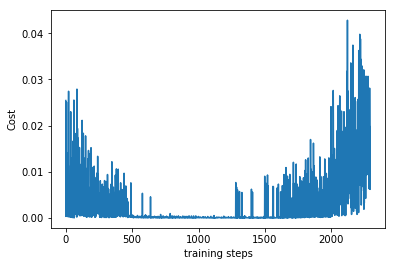

In [3]:
def run_maze():
    step = 0    # 用来控制什么时候学习
    for episode in range(300):
        # 初始化环境
        observation = env.reset()

        while True:
            # 刷新环境
            env.render()

            # DQN 根据观测值选择行为
            action = RL.choose_action(observation)

            # 环境根据行为给出下一个 state, reward, 是否终止
            observation_, reward, done = env.step(action)

            # DQN 存储记忆
            RL.store_transition(observation, action, reward, observation_)

            # 控制学习起始时间和频率 (先累积一些记忆再开始学习)
            if (step > 200) and (step % 5 == 0):
                RL.learn()

            # 将下一个 state_ 变为 下次循环的 state
            observation = observation_

            # 如果终止, 就跳出循环
            if done:
                break
            step += 1   # 总步数

    # end of game
    print('game over')
    env.destroy()


if __name__ == "__main__":
    env = Maze()
    RL = DeepQNetwork(env.n_actions, env.n_features,
                      learning_rate=0.01,
                      reward_decay=0.9,
                      e_greedy=0.9,
                      replace_target_iter=200,  # 每 200 步用 eval_net 替换一次 target_net 的参数
                      memory_size=2000, # 记忆上限
                      output_graph=False   # 是否输出 tensorboard 文件
                      )
    env.after(100, run_maze)
    env.mainloop()
    RL.plot_cost()  # 观看神经网络的误差曲线

如果把上面程序的output_graph变量设置为True，启动后，在**项目所在目录**执行cmd命令： tensorboard --logdir=logs(**和代码输出网络结构的目录一致**)，然后在浏览器访问： http://localhost:6006 ，在Graphs选项页可以看到网络结构。
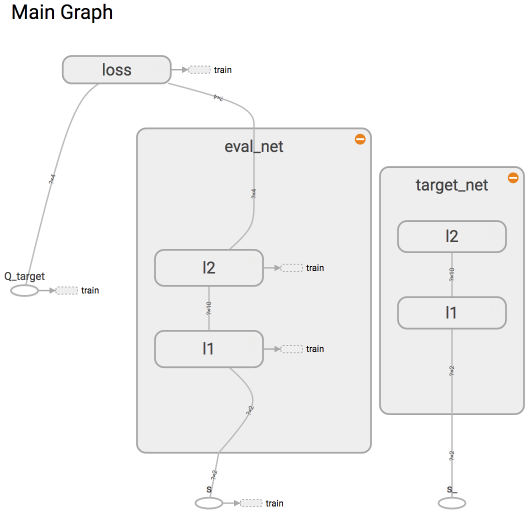

输出的误差曲线如下（不是不断下降的，因为不断有新的学习样本加入，不像拟合任务，训练样本固定的）
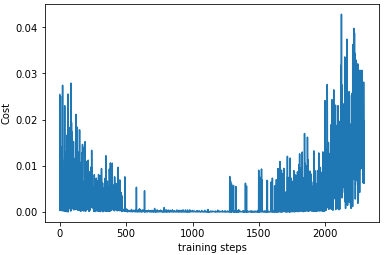